In [36]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import statsmodels.api as sm

import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

plt.rc("font", family="Malgun Gothic")
plt.rc("axes", unicode_minus=False)

In [37]:
df_1=pd.read_csv('Seoul_full.csv')

In [38]:
df_2=pd.read_csv('Seoul_full_test.csv')

In [39]:
dtypes = df_1.dtypes
encoders = {}
for column in df_1.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(df_1[column])
        encoders[column] = encoder
        
df_1_num = df_1.copy()        
for column in encoders.keys():
    encoder = encoders[column]
    df_1_num[column] = encoder.transform(df_1[column])

In [40]:
dtypes = df_2.dtypes
encoders = {}
for column in df_2.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(df_2[column])
        encoders[column] = encoder
        
df_2_num = df_2.copy()        
for column in encoders.keys():
    encoder = encoders[column]
    df_2_num[column] = encoder.transform(df_2[column])

In [41]:
y_train=df_1_num.loc[:,'이용금액']
X_train=df_1_num.loc[:,df_1_num.columns !='이용금액']

y_test=df_2_num.loc[:,'이용금액']
X_test=df_2_num.loc[:,df_2_num.columns !='이용금액']

In [42]:
X_test

,년,월,매장_시군구,업종명,성별,가구생애주기,이용고객수,이용건수,유입,확진자수
0,2020,4,0,0,1,1,39,39,7,23.0
1,2020,4,0,0,1,2,63,69,6,23.0
2,2020,4,0,0,1,3,47,49,4,23.0
3,2020,4,0,0,1,4,49,78,4,23.0
4,2020,4,0,0,1,5,44,54,3,23.0
...,...,...,...,...,...,...,...,...,...,...
6739,2020,4,24,38,2,1,562,655,10,3.0
6740,2020,4,24,38,2,2,512,592,11,3.0
6741,2020,4,24,38,2,3,327,399,7,3.0
6742,2020,4,24,38,2,4,1143,1333,18,3.0


In [43]:
X=pd.concat([X_train,X_test])
y=pd.concat([y_train,y_test])

In [44]:
# define regressor type, and fit with train set
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [45]:
regressor.coef_

array([-3.04021001e+06, -1.35452741e+05, -1.19996018e+06, -1.02832854e+05,
       -1.31401496e+07,  1.88244693e+07,  7.45719233e+03,  5.35127805e+03,
        3.33983953e+06, -2.81056177e+05])

In [46]:
y_pred = regressor.predict(X_test)

Text(0.5, 0, 'True (ground truth)')

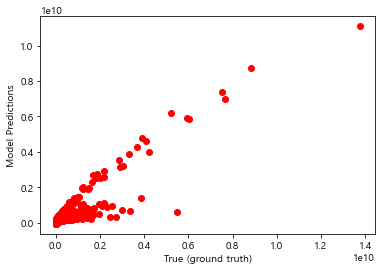

In [47]:
plt.scatter(y_test, y_pred, color = 'r')
plt.ylabel('Model Predictions')
plt.xlabel('True (ground truth)')

In [49]:
print(regressor.score(X_train, y_train))

0.783820182256408


In [14]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from math import sqrt

k = X_test.shape[1]
n = len(X_test)

# RMSE(평균 제곱근 오차(Root Mean Square Error))
# https://en.wikipedia.org/wiki/Root-mean-square_deviation
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))

MSE = mean_squared_error(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
adj_r2 = 1-(1-r2)*(n-1)/(n-k-1)
MAPE = np.mean( np.abs((y_test - y_pred) / y_test ) ) * 100

print('RMSE =',RMSE, 
      '\nMSE =',MSE, 
      '\nMAE =',MAE, 
      '\nR2 =', r2, 
      '\nAdjusted R2 =', adj_r2, 
      '\nMean Absolute Percentage Error =', MAPE, '%') 


RMSE = 161063170.12060872 
MSE = 2.5941344769300144e+16 
MAE = 73543854.57618052 
R2 = 0.813863587532134 
Adjusted R2 = 0.8135871336297608 
Mean Absolute Percentage Error = 2876.405977629468 %


In [15]:
from scipy import stats
# https://stackoverflow.com/questions/27928275/find-p-value-significance-in-scikit-learn-linearregression

params = np.append(regressor.intercept_,regressor.coef_)
predictions = regressor.predict(X_train)

newX = pd.DataFrame({"Constant":np.ones(len(X_train))}).join(pd.DataFrame(X_train.reset_index(drop=True)))
MSE = (sum((y_train-predictions)**2))/(len(newX)-len(newX.columns))

# Note if you don't want to use a DataFrame replace the two lines above with
# newX = np.append(np.ones((len(X_train),1)), X, axis=1)
# MSE = (sum((y_train-predictions)**2))/(len(newX)-len(newX[0]))

var_b = MSE*(np.linalg.pinv(np.dot(newX.T,newX)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params/ sd_b

p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(newX.values[0])))) for i in ts_b]


sd_b = np.round(sd_b,3)
ts_b = np.round(ts_b,3)
p_values = np.round(p_values,3)
params = np.round(params,4)

df_summary = pd.DataFrame()
df_summary["Coefficients"],df_summary["Standard Errors"],df_summary["t values"],df_summary["Probabilities"] = [params,sd_b,ts_b,p_values]
df_summary.index = ['constant'] + list(X_train.columns)
df_summary

,Coefficients,Standard Errors,t values,Probabilities
constant,6.102645e+09,4.920,1.240259e+09,0.000
년,-3.040210e+06,1572.048,-1.933917e+03,0.000
월,-1.354527e+05,178724.203,-7.580000e-01,0.449
매장_시군구,-1.199960e+06,88250.324,-1.359700e+01,0.000
업종명,-1.028329e+05,59908.224,-1.717000e+00,0.086
성별,-1.314015e+07,1283908.414,-1.023400e+01,0.000
가구생애주기,1.882447e+07,462556.257,4.069700e+01,0.000
이용고객수,7.457192e+03,114.168,6.531800e+01,0.000
이용건수,5.351278e+03,32.910,1.626030e+02,0.000
유입,3.339840e+06,40901.950,8.165500e+01,0.000


* P값이 유의유준 이상인 월을 제거한 모형


In [25]:
del df_1['월']
del df_2['월']

In [26]:
dtypes = df_1.dtypes
encoders = {}
for column in df_1.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(df_1[column])
        encoders[column] = encoder
        
df_1_num = df_1.copy()        
for column in encoders.keys():
    encoder = encoders[column]
    df_1_num[column] = encoder.transform(df_1[column])

dtypes = df_2.dtypes
encoders = {}
for column in df_2.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(df_2[column])
        encoders[column] = encoder
        
df_2_num = df_2.copy()        
for column in encoders.keys():
    encoder = encoders[column]
    df_2_num[column] = encoder.transform(df_2[column])

In [27]:
y_train=df_1_num.loc[:,'이용금액']
X_train=df_1_num.loc[:,df_1_num.columns !='이용금액']

y_test=df_2_num.loc[:,'이용금액']
X_test=df_2_num.loc[:,df_2_num.columns !='이용금액']

In [28]:
X=pd.concat([X_train,X_test])
y=pd.concat([y_train,y_test])

In [29]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [30]:
regressor.coef_

array([-2.38699572e+06, -1.19956765e+06, -1.02709160e+05, -1.31399395e+07,
        1.88244951e+07,  7.45730155e+03,  5.35122420e+03,  3.33969736e+06,
       -2.67366965e+05])

In [31]:
y_pred = regressor.predict(X_test)

Text(0.5, 0, 'True (ground truth)')

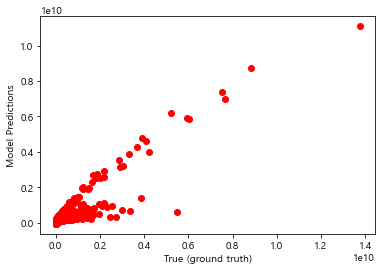

In [32]:
plt.scatter(y_test, y_pred, color = 'r')
plt.ylabel('Model Predictions')
plt.xlabel('True (ground truth)')

In [33]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from math import sqrt

k = X_test.shape[1]
n = len(X_test)

# RMSE(평균 제곱근 오차(Root Mean Square Error))
# https://en.wikipedia.org/wiki/Root-mean-square_deviation
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))

MSE = mean_squared_error(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
adj_r2 = 1-(1-r2)*(n-1)/(n-k-1)
MAPE = np.mean( np.abs((y_test - y_pred) / y_test ) ) * 100

print('RMSE =',RMSE, 
      '\nMSE =',MSE, 
      '\nMAE =',MAE, 
      '\nR2 =', r2, 
      '\nAdjusted R2 =', adj_r2, 
      '\nMean Absolute Percentage Error =', MAPE, '%') 

RMSE = 161065570.6352006 
MSE = 2.594211804404279e+16 
MAE = 73586575.21114275 
R2 = 0.8138580390693334 
Adjusted R2 = 0.8136092600897706 
Mean Absolute Percentage Error = 2862.6525631672425 %


In [34]:
from scipy import stats
# https://stackoverflow.com/questions/27928275/find-p-value-significance-in-scikit-learn-linearregression

params = np.append(regressor.intercept_,regressor.coef_)
predictions = regressor.predict(X_train)

newX = pd.DataFrame({"Constant":np.ones(len(X_train))}).join(pd.DataFrame(X_train.reset_index(drop=True)))
MSE = (sum((y_train-predictions)**2))/(len(newX)-len(newX.columns))

# Note if you don't want to use a DataFrame replace the two lines above with
# newX = np.append(np.ones((len(X_train),1)), X, axis=1)
# MSE = (sum((y_train-predictions)**2))/(len(newX)-len(newX[0]))

var_b = MSE*(np.linalg.pinv(np.dot(newX.T,newX)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params/ sd_b

p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(newX.values[0])))) for i in ts_b]


sd_b = np.round(sd_b,3)
ts_b = np.round(ts_b,3)
p_values = np.round(p_values,3)
params = np.round(params,4)

df_summary = pd.DataFrame()
df_summary["Coefficients"],df_summary["Standard Errors"],df_summary["t values"],df_summary["Probabilities"] = [params,sd_b,ts_b,p_values]
df_summary.index = ['constant'] + list(X_train.columns)
df_summary

,Coefficients,Standard Errors,t values,Probabilities
constant,4.782879e+09,1.139,4.200063e+09,0.000
년,-2.386996e+06,1490.541,-1.601430e+03,0.000
매장_시군구,-1.199568e+06,88249.958,-1.359300e+01,0.000
업종명,-1.027092e+05,59906.813,-1.714000e+00,0.086
성별,-1.313994e+07,1283903.993,-1.023400e+01,0.000
가구생애주기,1.882450e+07,462551.238,4.069700e+01,0.000
이용고객수,7.457301e+03,114.167,6.531900e+01,0.000
이용건수,5.351224e+03,32.910,1.626020e+02,0.000
유입,3.339697e+06,40897.468,8.166000e+01,0.000
확진자수,-2.673670e+05,105881.972,-2.525000e+00,0.012
